# Training a model

In [1]:
from rastervision.core.data import ClassConfig

class_config = ClassConfig(
    names=['background', 'building'], 
    colors=['lightgray', 'darkred'],
    null_class='background')

To keep things simple, we use one scene for training and one for validation. In a real workflow, we would normally use many more scenes.

In [2]:
train_image_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/images/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif'
train_label_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson'

In [3]:
val_image_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/images/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13.tif'
val_label_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/labels/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13_Buildings.geojson'

In [4]:
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset,
    SemanticSegmentationSlidingWindowGeoDataset,
    SemanticSegmentationVisualizer)

import albumentations as A

viz = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors)

In [5]:
data_augmentation_transform = A.Compose([
    A.Flip(),
    A.ShiftScaleRotate(),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=10),
        A.RGBShift(),
        A.ToGray(),
        A.ToSepia(),
        A.RandomBrightness(),
        A.RandomGamma(),
    ]),
    A.CoarseDropout(max_height=32, max_width=32, max_holes=5)
])

train_ds = SemanticSegmentationRandomWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=train_image_uri,
    label_vector_uri=train_label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    size_lims=(150, 200),
    out_size=256,
    max_windows=400,
    transform=data_augmentation_transform)

len(train_ds)

2022-10-21 13:53:52:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/images/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif.
2022-10-21 13:53:52:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson.


400

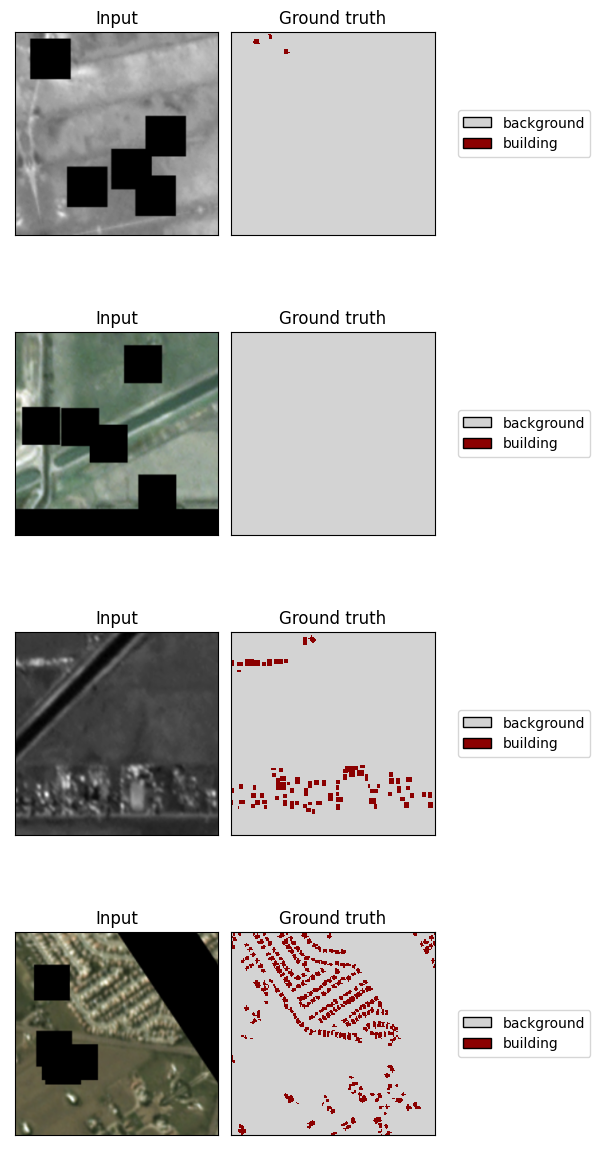

In [8]:
x, y = viz.get_batch(train_ds, 4)
viz.plot_batch(x, y, show=True)

In [6]:
val_ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=val_image_uri,
    label_vector_uri=val_label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    size=200,
    stride=100,
    transform=A.Resize(256, 256))

len(val_ds)

2022-10-21 13:53:54:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/images/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13.tif.
2022-10-21 13:53:54:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/labels/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13_Buildings.geojson.


121

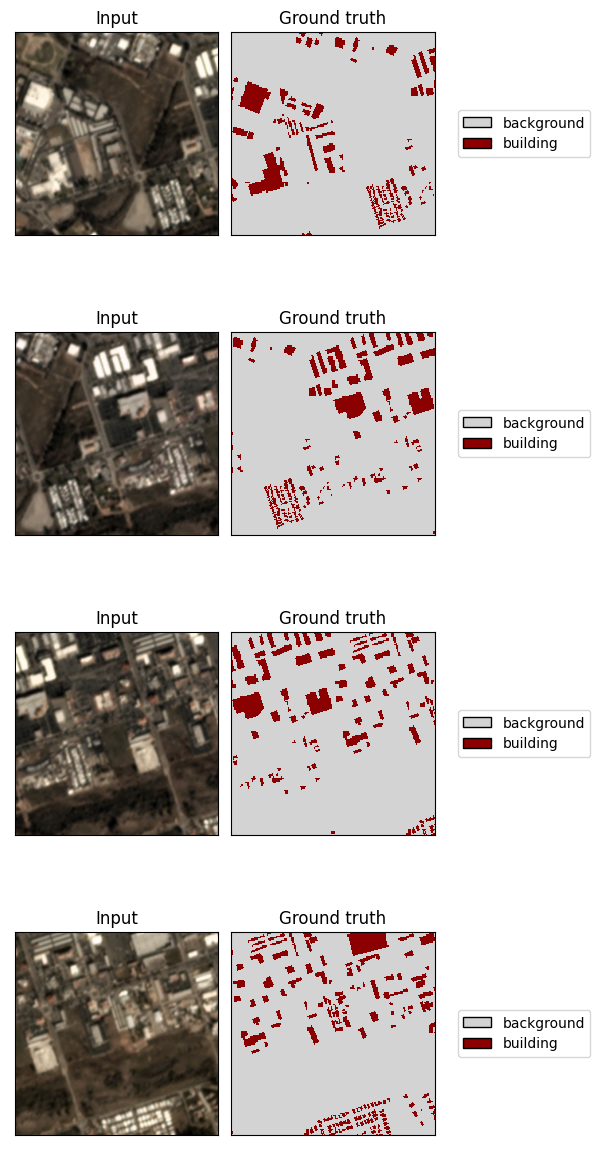

In [10]:
x, y = viz.get_batch(val_ds, 4)
viz.plot_batch(x, y, show=True)

## Define model

Use a [light-weight panoptic FPN model](https://github.com/AdeelH/pytorch-fpn) with a ResNet-18 backbone.

In [7]:
import torch

model = torch.hub.load(
    'AdeelH/pytorch-fpn',
    'make_fpn_resnet',
    name='resnet18',
    fpn_type='panoptic',
    num_classes=len(class_config),
    fpn_channels=128,
    in_channels=3,
    out_size=(256, 256),
    pretrained=True)

Using cache found in /root/.cache/torch/hub/AdeelH_pytorch-fpn_master


## Configure the training

In [8]:
from rastervision.pytorch_learner import SemanticSegmentationGeoDataConfig

data_cfg = SemanticSegmentationGeoDataConfig(
    class_names=class_config.names,
    class_colors=class_config.colors,
    num_workers=0, # increase to use multi-processing
)

In [9]:
from rastervision.pytorch_learner import SolverConfig

solver_cfg = SolverConfig(
    batch_sz=8,
    lr=3e-2,
    class_loss_weights=[1., 10.]
)

In [10]:
from rastervision.pytorch_learner import SemanticSegmentationLearnerConfig

learner_cfg = SemanticSegmentationLearnerConfig(data=data_cfg, solver=solver_cfg)

In [11]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner(
    cfg=learner_cfg,
    output_dir='./train-demo/',
    model=model,
    train_ds=train_ds,
    valid_ds=val_ds)

In [12]:
learner.log_data_stats()

2022-10-21 13:54:04:rastervision.pytorch_learner.learner: INFO - train_ds: 400 items
2022-10-21 13:54:04:rastervision.pytorch_learner.learner: INFO - valid_ds: 121 items


## Run `Tensorboard` for monitoring

In [13]:
%load_ext tensorboard

This will start an instance of tensorboard and embed it in the output of the cell:

In [ ]:
%tensorboard --bind_all --logdir "./train-demo/tb-logs" --reload_interval 10 

![A screenshot of the Tensorboard dashboard.](../../img/tensorboard.png "A screenshot of the Tensorboard dashboard.")


In [15]:
learner.train(epochs=3)

2022-10-21 13:54:07:rastervision.pytorch_learner.learner: INFO - epoch: 0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

2022-10-21 13:54:31:rastervision.pytorch_learner.learner: INFO - metrics:
{'avg_f1': 0.9063443541526794,
 'avg_precision': 0.9242058992385864,
 'avg_recall': 0.8891600370407104,
 'background_f1': 0.9402472376823425,
 'background_precision': 0.963484525680542,
 'background_recall': 0.9181045889854431,
 'building_f1': 0.23569801449775696,
 'building_precision': 0.1801292449235916,
 'building_recall': 0.34084731340408325,
 'epoch': 0,
 'train_loss': 0.04628021240234375,
 'train_time': '0:00:15.237473',
 'val_loss': 0.06725204735994339,
 'valid_time': '0:00:08.886707'}
2022-10-21 13:54:31:rastervision.pytorch_learner.learner: INFO - epoch: 1


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

2022-10-21 13:54:55:rastervision.pytorch_learner.learner: INFO - metrics:
{'avg_f1': 0.8758389949798584,
 'avg_precision': 0.9373558759689331,
 'avg_recall': 0.8218992948532104,
 'background_f1': 0.898644208908081,
 'background_precision': 0.9779720902442932,
 'background_recall': 0.8312200903892517,
 'building_f1': 0.26652103662490845,
 'building_precision': 0.16794010996818542,
 'building_recall': 0.6453303098678589,
 'epoch': 1,
 'train_loss': 0.02682020902633667,
 'train_time': '0:00:15.355702',
 'val_loss': 0.06331045925617218,
 'valid_time': '0:00:08.924265'}
2022-10-21 13:54:56:rastervision.pytorch_learner.learner: INFO - epoch: 2


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

2022-10-21 13:55:21:rastervision.pytorch_learner.learner: INFO - metrics:
{'avg_f1': 0.887840986251831,
 'avg_precision': 0.9439790844917297,
 'avg_recall': 0.8380051851272583,
 'background_f1': 0.9082092046737671,
 'background_precision': 0.9833714962005615,
 'background_recall': 0.8437208533287048,
 'building_f1': 0.31117182970046997,
 'building_precision': 0.19774767756462097,
 'building_recall': 0.729731023311615,
 'epoch': 2,
 'train_loss': 0.028932266235351563,
 'train_time': '0:00:16.125036',
 'val_loss': 0.052588216960430145,
 'valid_time': '0:00:09.313433'}


## Train some more

In [16]:
learner.train(epochs=3)

2022-10-21 13:55:23:rastervision.pytorch_learner.learner: INFO - epoch: 3


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

2022-10-21 13:55:48:rastervision.pytorch_learner.learner: INFO - metrics:
{'avg_f1': 0.8662914633750916,
 'avg_precision': 0.9477248191833496,
 'avg_recall': 0.7977450489997864,
 'background_f1': 0.8820752501487732,
 'background_precision': 0.9884632229804993,
 'background_recall': 0.7963629961013794,
 'building_f1': 0.2900361716747284,
 'building_precision': 0.17599470913410187,
 'building_recall': 0.8239251375198364,
 'epoch': 3,
 'train_loss': 0.02868288040161133,
 'train_time': '0:00:16.083816',
 'val_loss': 0.05553163215517998,
 'valid_time': '0:00:09.339830'}
2022-10-21 13:55:49:rastervision.pytorch_learner.learner: INFO - epoch: 4


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

2022-10-21 13:56:14:rastervision.pytorch_learner.learner: INFO - metrics:
{'avg_f1': 0.9257288575172424,
 'avg_precision': 0.9331725239753723,
 'avg_recall': 0.918402910232544,
 'background_f1': 0.9565563201904297,
 'background_precision': 0.9676290154457092,
 'background_recall': 0.9457340836524963,
 'building_f1': 0.3299404978752136,
 'building_precision': 0.28044360876083374,
 'building_recall': 0.4006538987159729,
 'epoch': 4,
 'train_loss': 0.029659500122070314,
 'train_time': '0:00:15.839903',
 'val_loss': 0.056976836174726486,
 'valid_time': '0:00:09.132699'}
2022-10-21 13:56:15:rastervision.pytorch_learner.learner: INFO - epoch: 5


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

2022-10-21 13:56:39:rastervision.pytorch_learner.learner: INFO - metrics:
{'avg_f1': 0.9225586652755737,
 'avg_precision': 0.9400836825370789,
 'avg_recall': 0.9056751132011414,
 'background_f1': 0.9490233063697815,
 'background_precision': 0.9750348925590515,
 'background_recall': 0.9243635535240173,
 'building_f1': 0.3696795403957367,
 'building_precision': 0.27798280119895935,
 'building_recall': 0.5516492128372192,
 'epoch': 5,
 'train_loss': 0.02884626865386963,
 'train_time': '0:00:15.232563',
 'val_loss': 0.058977968990802765,
 'valid_time': '0:00:08.873377'}


2022-10-21 14:00:43:rastervision.pytorch_learner.learner: INFO - Plotting predictions...


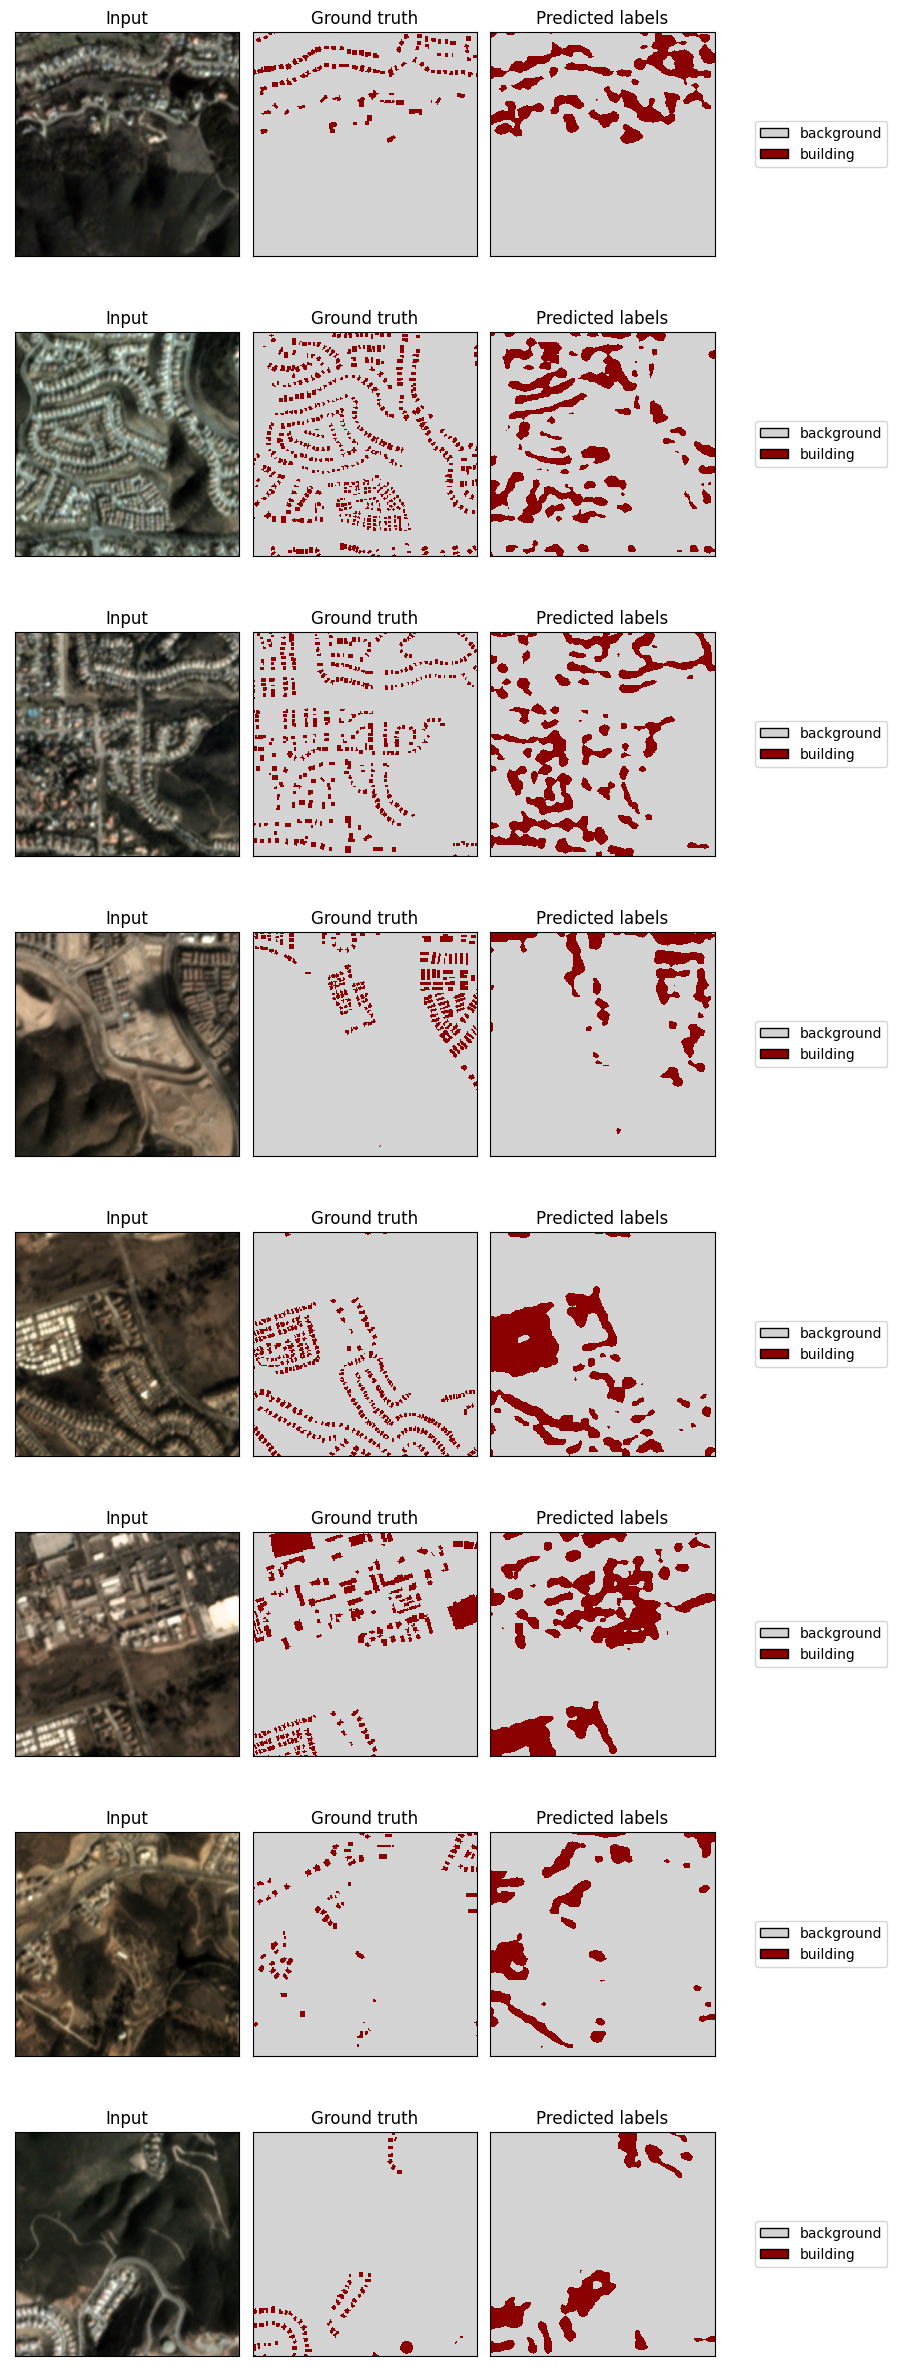

<Figure size 640x480 with 0 Axes>

In [19]:
learner.plot_predictions(split='valid', show=True)

In [20]:
learner.save_model_bundle()

2022-10-21 14:00:53:rastervision.pytorch_learner.learner: INFO - Creating bundle.
2022-10-21 14:00:53:rastervision.pytorch_learner.learner: INFO - Saving bundle to ./train-demo/model-bundle.zip.


## Examine learner output

In [21]:
!apt-get install tree > "/dev/null"

debconf: delaying package configuration, since apt-utils is not installed


In [22]:
!tree "./train-demo/"

./train-demo/
├── last-model.pth
├── learner-config.json
├── log.csv
├── model-bundle.zip
├── tb-logs
│   └── events.out.tfevents.1666360444.8f1b6ac234ab.438.0
└── valid_preds.png

1 directory, 6 files
